In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../Data/Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [4]:
df.columns = ['Production']

In [5]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


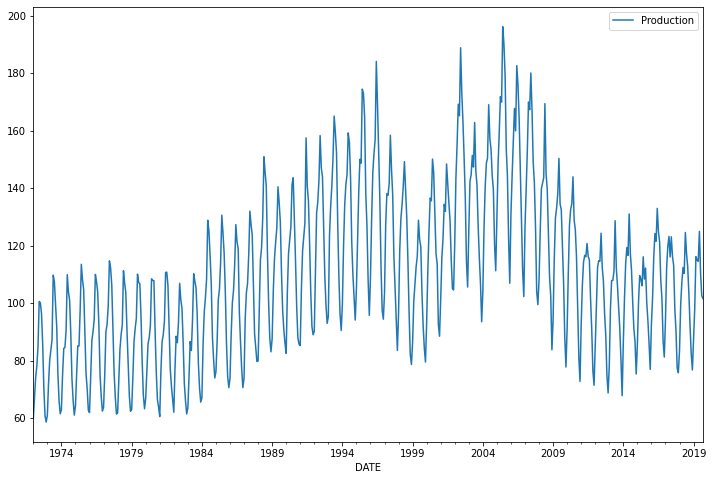

In [6]:
df.plot(figsize=(12,8))

In [37]:
test_size = 18
test_ind = len(df)- test_size

In [38]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [39]:
len(test)

18

In [40]:
from sklearn.preprocessing import MinMaxScaler

In [41]:
scaler = MinMaxScaler()

In [42]:
scaler.fit(train)

MinMaxScaler()

In [43]:
scaled_train = scaler.transform(train)

In [44]:
scaled_test = scaler.transform(test)

In [45]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [56]:
length = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [58]:
model = Sequential()
model.add(LSTM(150,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [59]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [60]:
valid_gen = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [61]:
from tensorflow.keras.callbacks import EarlyStopping

In [62]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [63]:
model.fit_generator(generator,epochs=20,validation_data=valid_gen,callbacks=[early_stop])

Epoch 1/20
543/543 [==============================] - 6s 11ms/step - loss: 0.0189 - val_loss: 0.0103
Epoch 2/20
543/543 [==============================] - 5s 10ms/step - loss: 0.0064 - val_loss: 0.0029
Epoch 3/20
543/543 [==============================] - 5s 10ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 4/20
543/543 [==============================] - 5s 9ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 5/20
543/543 [==============================] - 5s 9ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 6/20
543/543 [==============================] - 5s 9ms/step - loss: 0.0038 - val_loss: 0.0022


In [64]:
losses = pd.DataFrame(model.history.history)

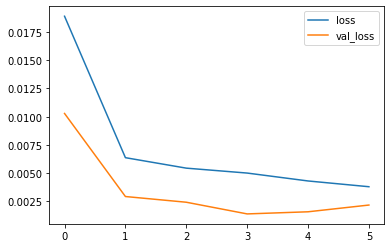

In [65]:
losses.plot()

In [66]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [67]:
test_predictions

[array([0.44201675], dtype=float32),
 array([0.47579676], dtype=float32),
 array([0.49107736], dtype=float32),
 array([0.46022832], dtype=float32),
 array([0.3992479], dtype=float32),
 array([0.3017563], dtype=float32),
 array([0.21277586], dtype=float32),
 array([0.15065894], dtype=float32),
 array([0.14210285], dtype=float32),
 array([0.18881354], dtype=float32),
 array([0.28034002], dtype=float32),
 array([0.37286705], dtype=float32),
 array([0.45521283], dtype=float32),
 array([0.5055658], dtype=float32),
 array([0.51939994], dtype=float32),
 array([0.48960128], dtype=float32),
 array([0.4173105], dtype=float32),
 array([0.3164684], dtype=float32)]

In [68]:
true_predictions = scaler.inverse_transform(test_predictions)

In [69]:
test['Predictions'] = true_predictions

c:\users\qadri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [70]:
test

,Production,Predictions
DATE,,
2018-04-01,112.4309,119.443247
2018-05-01,110.3544,124.088468
2018-06-01,124.5841,126.189763
2018-07-01,117.2215,121.947592
2018-08-01,112.6779,113.561938
2018-09-01,103.3118,100.155485
2018-10-01,92.1321,87.919438
2018-11-01,82.4347,79.377498
2018-12-01,76.7608,78.200917


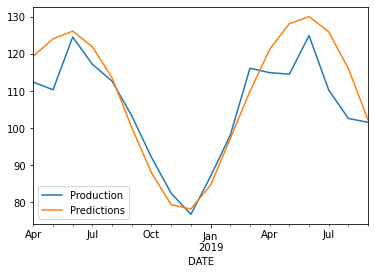

In [71]:
test.plot()

In [72]:
from sklearn.metrics import mean_squared_error

In [73]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

7.555127801050675

In [74]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

NameError: name 'scaled_full_data' is not defined

In [76]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [77]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [79]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=6)

Epoch 1/6
561/561 [==============================] - 6s 10ms/step - loss: 0.0184
Epoch 2/6
561/561 [==============================] - 5s 9ms/step - loss: 0.0059
Epoch 3/6
561/561 [==============================] - 5s 10ms/step - loss: 0.0055
Epoch 4/6
561/561 [==============================] - 5s 10ms/step - loss: 0.0040
Epoch 5/6
561/561 [==============================] - 5s 10ms/step - loss: 0.0040
Epoch 6/6
561/561 [==============================] - 5s 8ms/step - loss: 0.0044


In [80]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [81]:
forecast = scaler.inverse_transform(forecast)

In [82]:
df


,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


In [83]:
forecast_index = pd.date_range(start='2019-10-01',periods=periods,freq='MS')

In [84]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [85]:
forecast_df

,Forecast
2019-10-01,92.500341
2019-11-01,85.978238
2019-12-01,84.159792
2020-01-01,90.634253
2020-02-01,102.644621
2020-03-01,113.509874
2020-04-01,119.431575
2020-05-01,124.192612
2020-06-01,125.199692
2020-07-01,118.715778


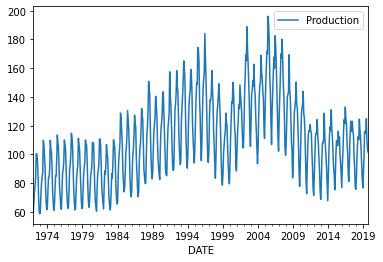

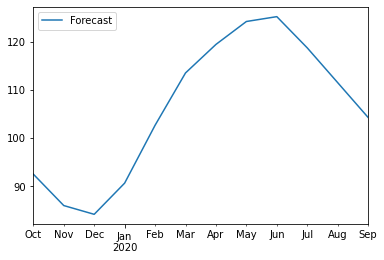

In [86]:
df.plot()
forecast_df.plot()

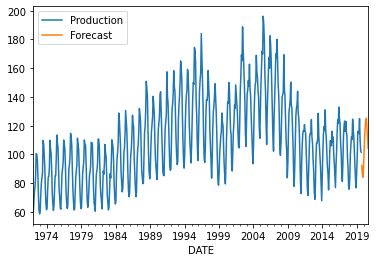

In [87]:
ax = df.plot()
forecast_df.plot(ax=ax)

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')